In [178]:
import warnings
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from category_encoders import OneHotEncoder
from sklearn.utils.validation import check_is_fitted



#from category_encoders import OneHotEncoder


plt.style.use('ggplot')



In [176]:
def wrangle(Desktop):
    # Read CSV file
    df = pd.read_csv(Desktop)
    #subset to property in Karachi
    mask_ka =df["complete location"].str.contains("Sindh").fillna(False)
    #sunset to House
    mask_ouse = df["type"]=="House"
    df = df[mask_ka & mask_ouse]
    
    #slipting 'price'
    df[["Price", "currency"]] = df["price"].str.split(" ", expand = True)

    df["Price"] = df["Price"].astype(float)
    #df.drop(columns = ("Price","currency"), inplace = True)

    #Changing the 'Price to Float' and converting  crore to lakh
    df = df.assign(price = lambda x: x["Price"].mask(x["currency"] == "Crore", x["Price"] * 100))
    
    #dropping columns
    df.drop(columns = ["Price","currency"], inplace = True)
    df.drop(columns = ["date added","keywords", "url"], inplace = True)
    
    #dropping NaN values
    df = df.dropna()
    
    
    #slipting area, replaying ',' and changing obj. to float
    df["area"] = df["area"].str.split(" ", expand = True)[0]
    df.area= df.area.apply(lambda x:(x.replace(',','')))
    df["area"] = df["area"].astype(float)
    
    #drop some columns
    df.drop(columns = ["title","complete location", "description"], inplace = True)



    

    


    return df

In [143]:
df = wrangle("karachi-pakistan-property-prices-2023.csv")
print("df shape:", df.shape)
df.head()

df shape: (3752, 6)


,price,type,bedrooms,bathrooms,area,location
0,1150.0,House,5,6,600.0,"DHA Defence, Karachi, Sindh"
5,900.0,House,7,6,500.0,"DHA Defence, Karachi, Sindh"
11,2000.0,House,6,6,1000.0,"DHA Defence, Karachi, Sindh"
14,1700.0,House,6,6,500.0,"DHA Defence, Karachi, Sindh"
16,725.0,House,3,4,545.0,"DHA Defence, Karachi, Sindh"


In [144]:
df.columns

Index(['price', 'type', 'bedrooms', 'bathrooms', 'area', 'location'], dtype='object')

In [145]:
df.dtypes

price        float64
type          object
bedrooms       int64
bathrooms      int64
area         float64
location      object
dtype: object

In [146]:
df.isnull().sum()

price        0
type         0
bedrooms     0
bathrooms    0
area         0
location     0
dtype: int64

In [147]:
df["location"].value_counts()

DHA Defence, Karachi, Sindh            2087
Bahria Town Karachi, Karachi, Sindh    1570
Clifton, Karachi, Sindh                  95
Name: location, dtype: int64

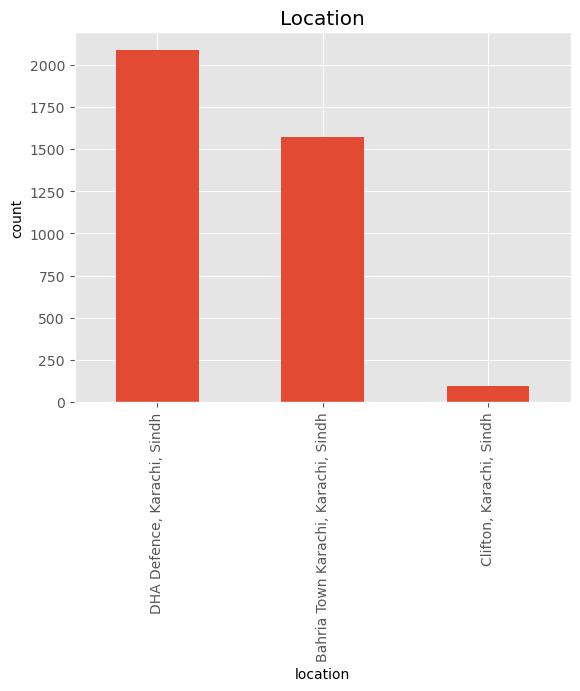

In [148]:
ax = df['location'].value_counts()\
.plot(kind='bar', title = "Location")
ax.set_xlabel("location")
ax.set_ylabel("count");

In [149]:
df["bedrooms"].value_counts()

3     1051
6      910
4      833
5      764
7      109
8       35
9       20
2       16
10      12
1        1
11       1
Name: bedrooms, dtype: int64

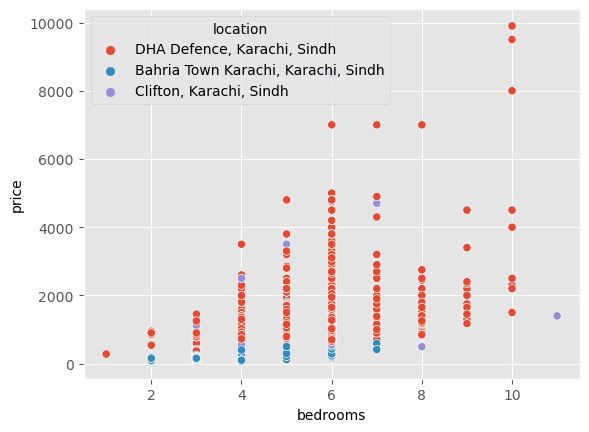

In [150]:
sns.scatterplot(x = "bedrooms",
                y = "price",
                hue = "location",
               data = df);

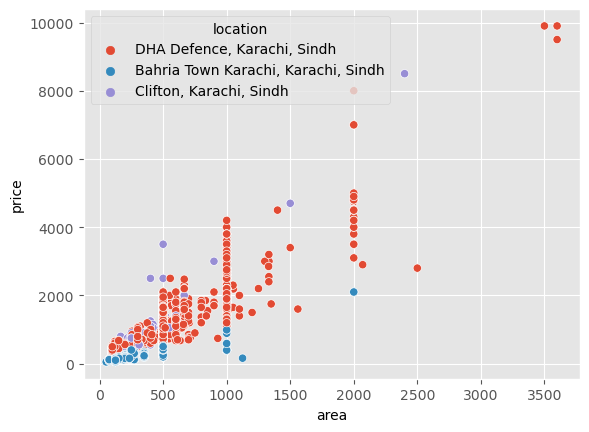

In [153]:
sns.scatterplot(x = "area",
                y = "price",
                hue = "location",
               data = df);

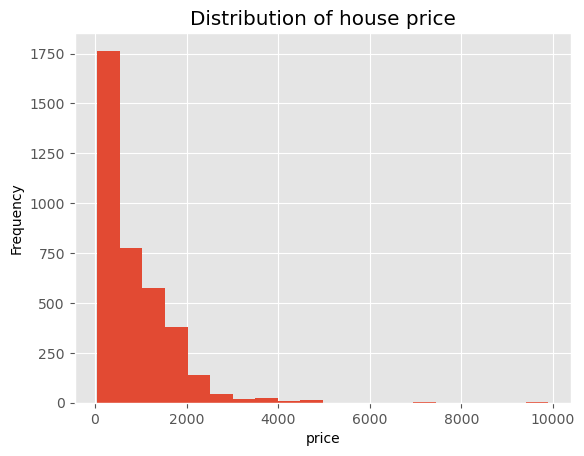

In [151]:
ax = df['price'].plot(kind="hist", 
                          bins=20, 
                          title = "Distribution of house price")
ax.set_xlabel("price")
ax.set_ylabel("Frequency");

In [156]:
df_corr = df[["price",  
    "bedrooms","bathrooms", "area",]].corr()
df_corr

,price,bedrooms,bathrooms,area
price,1.000000,0.674244,0.674083,0.876632
bedrooms,0.674244,1.000000,0.908495,0.681850
bathrooms,0.674083,0.908495,1.000000,0.650728
area,0.876632,0.681850,0.650728,1.000000


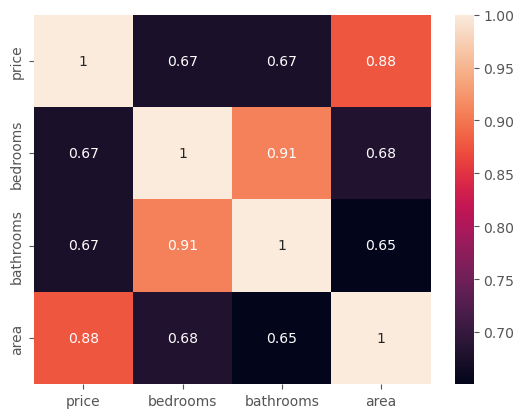

In [157]:
sns.heatmap(df_corr, annot = True);

In [158]:
df.head()

,price,type,bedrooms,bathrooms,area,location
0,1150.0,House,5,6,600.0,"DHA Defence, Karachi, Sindh"
5,900.0,House,7,6,500.0,"DHA Defence, Karachi, Sindh"
11,2000.0,House,6,6,1000.0,"DHA Defence, Karachi, Sindh"
14,1700.0,House,6,6,500.0,"DHA Defence, Karachi, Sindh"
16,725.0,House,3,4,545.0,"DHA Defence, Karachi, Sindh"


In [160]:
target = "price"
features = ["bedrooms","bathrooms","area","location"]
y_train = df[target]
X_train = df[features]

In [161]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 844.59
Baseline MAE: 602.7381706757108


In [162]:
X_train.head()

,bedrooms,bathrooms,area,location
0,5,6,600.0,"DHA Defence, Karachi, Sindh"
5,7,6,500.0,"DHA Defence, Karachi, Sindh"
11,6,6,1000.0,"DHA Defence, Karachi, Sindh"
14,6,6,500.0,"DHA Defence, Karachi, Sindh"
16,3,4,545.0,"DHA Defence, Karachi, Sindh"


In [167]:
model = make_pipeline(
     OneHotEncoder(use_cat_names=True),
     SimpleImputer(),
     Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['location'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [168]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 217.9113547106758


In [184]:
#X_test = pd.read_csv("karachi-pakistan-property-prices-2023.csv")
#y_pred_test = pd.Series(model.predict(X_test))
#y_pred_test.head()

In [193]:
def make_prediction(bedrooms, bathrooms, area, location):
    data = {
        "bedrooms":bedrooms,
        "bathrooms":bathrooms,
        "area":area,
        "location":location
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted house price: ${prediction}"

In [194]:
make_prediction(5,6,600.0,"DHA Defence, Karachi, Sindh")

'Predicted house price: $1409.57'